In [1]:
import pandas as pd
import numpy as np
# from collections import defaultdict

# nlp pre-processing
from nltk.corpus import stopwords 

# nlp EDA
from wordcloud import WordCloud

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

# #img load
# from PIL import Image
# import requests
# from io import BytesIO
# from fake_useragent import UserAgent 

# #img preprocessing
# from keras.preprocessing import image
# from keras.applications import mobilenet_v2


# #show img
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# #remove warnings
# import tensorflow as tf
# # tf.logging.set_verbosity(tf.logging.ERROR)
# tf.get_logger().setLevel('ERROR')

# # color distributions
# # import os
# # os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)
# import cv2
# import imutils
# import urllib.request

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## load dataframes

In [103]:
img_link_df = pd.read_pickle('attractions_img_links_df.pkl')
att_loc_df = pd.read_pickle('attractions_loc_df.pkl')

## Clean Data

In [104]:
img_link_df.shape

(1423, 58)

In [105]:
att_loc_df.shape #different shape

(1469, 3)

In [106]:
#try removing duplicates
att_loc_df.drop_duplicates(subset = 'name',inplace=True)
att_loc_df.shape

(1423, 3)

In [107]:
# img_link_df['img_num'] = att_loc_df['img_num']
# img_link_df = img_link_df[img_link_df['img_num'] >= 50]
# img_link_df.drop('img_num', 1, inplace=True)

att_loc_df = att_loc_df[att_loc_df['img_num'] >= 50]

In [108]:
att_loc_df.shape

(1296, 3)

In [109]:
att_loc_df.head()

,name,location,img_num
0,Barber Vintage Motorsports Museum,"6030 Barber Motorsports, Birmingham, AL 35094-...",58
1,Rosa Parks Library and Museum,"251 Montgomery St 251 Montgomery Street, 36104...",58
3,U.S. Space and Rocket Center,"1 Tranquility Base, Huntsville, AL 35805-3371",58
4,Adventure Island,"24559 Perdido Beach Blvd, Orange Beach, AL 365...",58
5,Fairhope Municipal Pier,"Fairhope Avenue, Fairhope, AL 36532",58


### Pickle Data

In [399]:
att_loc_df.to_pickle('attractions_loc_df.pkl')

### Clean Attraction names

In [110]:
# nlp pre-processing
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

def clean_name(name , stop):
    '''
    clean comment string, removing numbers, punctuation, non alphabetical words, replacing words,
    stop words, and changing to lowercase, 
    lemmatizing and stemming
        
    input: 
    comment = comment to be cleaned,
    stop = stopwords,
    replace = dictionary of words to replace
        
    output: cleaned string
    '''
    s = str(name.lower()) #lowercase
    
    s = re.sub(r'[^\w\s]', '', s) #remmove punctuation
    
    s_token = word_tokenize(s) #tokenize
        
    s_token = [w.strip() for w in s_token] #remove spaces
        
    s_token = [w for w in s_token if w not in stop] #remove stop words
    
    lemmatizer = WordNetLemmatizer() # Init Lemmatizer
    s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token] #Lemmatize
        
    s_lemm = " ".join(s_token_lemm) #join back into one string
        
    return s_lemm

def display_topics(model, feature_names, no_top_words, topic_names):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def prob_df(X, topics):
    '''
    df of all documents as rows and the probablities of each topic as columns
        
    input: 
    X = model X components,
    topics = list of topic names,
        
    output: df 
    '''
    cols = topics

    df = pd.DataFrame(X.round(5), columns = cols)
    df['topic_choice'] = df.idxmax(axis=1)
    df['topic_value'] = df.max(axis=1)

    return df

In [111]:
stop = stopwords.words('english')
stop += ['national', 'american']
# stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

attr_topics = att_loc_df.copy()
attr_topics['cleaned_name'] = attr_topics.apply (lambda x: clean_name(x['name'], stop), axis=1)
attr_topics.head()

,name,location,img_num,cleaned_name
0,Barber Vintage Motorsports Museum,"6030 Barber Motorsports, Birmingham, AL 35094-...",58,barber vintage motorsports museum
1,Rosa Parks Library and Museum,"251 Montgomery St 251 Montgomery Street, 36104...",58,rosa park library museum
3,U.S. Space and Rocket Center,"1 Tranquility Base, Huntsville, AL 35805-3371",58,u space rocket center
4,Adventure Island,"24559 Perdido Beach Blvd, Orange Beach, AL 365...",58,adventure island
5,Fairhope Municipal Pier,"Fairhope Avenue, Fairhope, AL 36532",58,fairhope municipal pier


### EDA

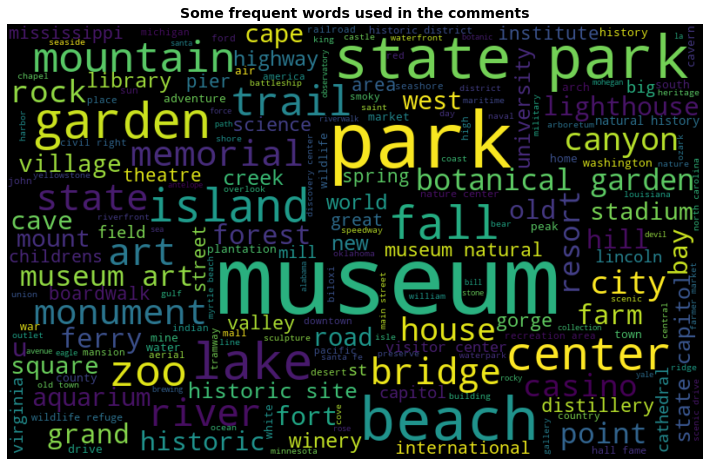

In [112]:
all_words = ' '.join([word for word in attr_topics['cleaned_name'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

## Topic Modeling

In [113]:
names = list(attr_topics['cleaned_name'])

### Count Vectorization

In [114]:
cv = CountVectorizer(stop_words=stop, min_df = 1) 
X_cv = cv.fit_transform(names)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [115]:
topics = 12
topic_words = 10
topic_names = ['science', 
               'parks',
               'beaches',
              'gardens/zoos',
              'government',
              'learning',
              'lakes',
              'monuments/historic_sites',
              'rivers',
              'art',
              'islands/lighthouses',
              'mountains',
              'history/war']

nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
display_topics(nmf_cv, cv.get_feature_names(), topic_words, topic_names)


Topic: ' science '
museum, history, natural, air, science, library, civil, mississippi, us, space

Topic: ' parks '
park, zoo, water, military, county, waterfront, cave, fall, point, spring

Topic: ' beaches '
beach, city, myrtle, boardwalk, rehoboth, lighthouse, virginia, bethany, public, south

Topic: ' gardens/zoos '
garden, botanical, zoo, botanic, japanese, arboretum, conservatory, desert, square, red

Topic: ' government '
state, capitol, louisiana, rock, cape, creek, building, memorial, forest, bridge

Topic: ' learning '
center, nature, visitor, discovery, science, hill, right, international, civil, interpretive

Topic: ' lakes '
lake, trail, champlain, area, rock, recreation, town, ferry, path, war

Topic: ' monuments/historic_sites '
historic, site, district, fort, monument, street, river, main, washita, city

Topic: ' rivers '
fall, trail, river, bridge, creek, cascade, area, nature, grand, canyon

Topic: ' art '
art, institute, museum, gallery, north, bridge, fine, univers

#### Latent Dirichlet Allocation (LDA) with Count Vectorization

In [116]:
topics = 7
topic_words = 8
topic_names = []

lda_cv = LatentDirichletAllocation(topics)
X_lda_cv = lda_cv.fit_transform(X_cv)
display_topics(lda_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
park, state, beach, island, fall, forest, zoo, house

Topic  1
museum, art, road, air, valley, civil, center, institute

Topic  2
trail, mountain, lake, park, highway, zoo, resort, county

Topic  3
museum, river, bridge, rock, memorial, fall, historic, hall

Topic  4
park, museum, center, history, monument, lake, aquarium, canyon

Topic  5
garden, museum, old, center, square, village, town, world

Topic  6
beach, state, park, capitol, zoo, garden, city, casino


### TF-IDF Vectorization

In [117]:
tfid = TfidfVectorizer(stop_words= stop, min_df=3)
X_tfid = tfid.fit_transform(names)

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization

In [118]:
topics = 11
topic_words = 6
topic_names = ['museums', 
               'parks',
               'beaches',
               'lakes',
              'gardens/zoos',
              'rivers',
              'parks',
              'landmarks',
              'art',
              'mountains',
              'seaside']

nmf_tfid = NMF(topics)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)
display_topics(nmf_tfid, tfid.get_feature_names(), topic_words, topic_names)


Topic: ' museums '
museum, history, air, natural, library, memorial

Topic: ' parks '
park, zoo, military, waterfront, water, riverfront

Topic: ' beaches '
beach, city, myrtle, boardwalk, lighthouse, south

Topic: ' lakes '
lake, trail, rock, town, ferry, michigan

Topic: ' gardens/zoos '
garden, botanical, zoo, japanese, botanic, square

Topic: ' rivers '
fall, trail, creek, river, grand, zoo

Topic: ' parks '
center, visitor, nature, discovery, science, trail

Topic: ' landmarks '
state, capitol, historic, rock, forest, louisiana

Topic: ' art '
art, institute, gallery, bridge, museum, north

Topic: ' mountains '
mountain, resort, mine, smoky, trail, casino

Topic: ' by_the_sea '
island, ferry, lighthouse, house, seashore, lakeshore


#### choose NMF with Count Vectorization

## Topic EDA & Cleaning

In [293]:
#get topic probablitity df
nmf_tfid_probs = prob_df(X_nmf_tfid, ['museums', 
               'parks',
               'beaches',
               'lakes',
              'gardens/zoos',
              'rivers',
              'landmarks',
              'parks',
              'art',
              'mountains',
              'seaside'])
nmf_tfid_probs.shape

(1296, 13)

In [294]:
attr_topics['category'] = list(nmf_tfid_probs['topic_choice'])
attr_topics.drop(['cleaned_name', 'img_num'], 1, inplace=True)
attr_topics.head()

KeyError: "['cleaned_name' 'img_num'] not found in axis"

#### Investigate Categories and manually change category or add location

In [454]:
category_words = {'Museum':'museums', 'Aquarium':'gardens/zoo', 'Stadium':'sports', 'Ampitheatre':'entertainment', 
                 'District':'entertainment','Historic House': 'landmarks', 'Pier': 'seaside', 'Theatre':'entertainment',
                 'Isle':'beaches','Glass':'art', 'Mall':'entertainment', 'Bend':'rivers', 'Gondola':'entertainment',
                 'Street':'entertainment', 'Habitat':'gardens/zoo', 'Whiskey':'entertainment',
                 'Distillery':'entertainment', 'Winery':'entertainment', 'Speedway':'sports',
                 'Orchards':'entertainment', 'Brewery':'entertainment', 'Mansion':'landmarks',
                 'Canyon':'mountains', 'Speedway':'sports', 'Overlook':'mountains', 'Science':'science',
                 'War':'war/memorial', 'Natural History':'science', 'Home':'landmarks', 'Peak':'mountains',
                 'Capitol':'government', 'Brewing':'entertainment', 'Library':'museums', 'Zoo':'gardens/zoo',
                 'Bourbon':'entertainment', 'Six Flags':'entertainment', 'Theme Park':'entertainment',
                 'State Park':'entertainment', 'Penitentiary':'landmarks', 'Historic Site':'landmarks',
                 'Water Park':'entertainment', 'Market Park':'entertainment', 'Historic District':'landmarks',
                 'Memorial':'war/memorial', 'Battleship':'war/memorial', 'USS':'war/memorial', 'Space':'science',
                 'Naval':'war/memorial', 'Lighthouse':'seaside', 'WW':'war/memorial', 'Birthplace':'landmarks',
                 'Strategic':'war/memorial', 'Air Force':'war/memorial', 'Military':'war/memorial', 'Spring':'rivers',
                 'Adventure':'entertainment', 'Botanical':'gardens/zoo', 'Sculpture':'art','Fair':'entertainment',
                 'Market':'entertainment', 'Fun':'entertainment', 'Plantation':'landmarks', 'Point':'mountains',
                 'River':'rivers', 'Historic Park':'landmarks', 'Field':'sports', 'Explor':'museums', 
                  'Monument':'landmarks', 'Downtown':'entertainment', 'Forest':'parks', 'Tower':'landmarks',
                 'Canal':'rivers', 'Arch':'landmarks', 'Mountain':'mountains'}

for key,value in category_words.items():
    attr_topics['category'] = pd.np.where(attr_topics['name'].str.contains(key), 
                                          value, attr_topics['category'])


<ipython-input-454-7a27541710cd>:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  attr_topics['category'] = pd.np.where(attr_topics['name'].str.contains(key),


In [455]:
loc_changes = {138:'S Main St, Breckenridge, CO 80424', 937:'3600 S Las Vegas Blvd, Las Vegas, NV 89109',
               1003:'6 W. Jackson St., Millersburg, OH 44654', 1047:None, 1117:'Benefit Street, Providence, RI',
               1198:'MP 31, SD-87, Custer, SD 57730', 1420:'1330 Oglebay Dr, Wheeling, West Virgina 26003'}

cat_changes = {7:'entertainment', 10:'landmarks',26:'entertainment', 29:'entertainment', 31:'landmarks',
                 34:'landmarks', 46:'landmarks', 54:'art', 55:'art', 88: 'war/memorial',
                  63:'art',  112: 'art',  141:'mountains', 147:'mountains', 156:'landmarks',
                175:'war/memorial', 188: 'lakes', 193:'entertainment', 217:'landmarks', 237: 'war/memorial',
               213:'entertainment', 234:'lakes', 243:'art', 262:'parks', 264:'art', 268:'art', 
                294:'sports',  314:'landmarks', 409: 'war/memorial',
                442:'landmarks', 453:'sports', 462:'sports', 458:'art',  475:'art', 504:'landmarks', 511:'landmarks',
               521:'seaside', 526:'landmarks', 570:'entertainment',
                591:'seaside', 601:'entertainment', 603:'parks', 634:'entertainment',
               660:'entertainment', 674:'entertainment', 689:'entertainment', 693:'landmarks', 
               711:'landmarks', 703:'landmarks',  739:'lakes', 766: 'war/memorial',
               741:'entertainment', 747:'mountains', 750:'landmarks', 849:'landmarks',
               855:'entertainment', 856:'rivers', 866:'entertainment', 900:'art', 907:'rivers', 919:'landmarks',
               922:'landmarks',  937:'entertainment', 939:'entertainment', 940:'entertainment',
               945:'landmarks',  959:'parks', 964:'art', 968:'entertainment', 975:'landmarks',
               981:'entertainment', 983:'entertainment', 984:'parks', 985:'entertainment', 1003:'entertainment',
               1021:'entertainment', 1022:'parks', 1030:'art', 1051:'landmarks', 1062:'landmarks', 
               1082:'landmarks', 1085:'entertainment',1090:'entertainment',1094:'entertainment',1105:'entertainment',
               1110:'landmarks', 1109:'landmarks', 1131:'park', 1117:'entertainment', 1154:'entertainment',
               1191:'entertainment', 1198:'mountains', 1210:'landmarks', 1218:'landmarks', 1213:'mountains',
               1214:'entertainment', 1227:'entertainment', 1242:'gardens/zoos', 1263:'gardens/zoos', 1261:'mountains',
               1268:'mountains', 1269:'mountains',1295:'landmarks',1296:'landmarks',1300:'landmarks',1306:'landmarks',
               1307:'landmarks', 1309:'landmarks',1331:'entertainment', 1340:'entertainment', 1386:'entertainment',  
               1387:'landmarks', 1388:'parks', 1420:'art', 1425:'entertainment', 1444:'entertainment' ,
              1049:'science', 11:'landmarks', 14:'beaches', 145:'entertainment', 68:'entertainment',555:'sports',
              510:'sports', 167:'beaches', 246:'beaches', 279:'entertainment', 316:'sports', 327:'entertainment',
              447:'sports', 460:'sports', 470:'entertainment', 556:'entertainment', 573:'seaside', 630:'rivers',
              638:'museums', 646:'entertainment', 692:'entertainment', 775:'entertainment', 801:'musuems',
              829:'sports'}

In [456]:
for key,value in cat_changes.items():
    attr_topics.loc[key]['category'] = value

for key,value in loc_changes.items():
    attr_topics.loc[key]['location'] = value

In [457]:
attr_topics_grouped = attr_topics.groupby('category')

In [458]:
attr_topics_grouped.get_group('parks')[:25]

,name,location,category
81,Tonto National Forest,,parks
139,Colorado Chautauqua: Park,"900 Baseline Rd, Boulder, CO 80302-7547",parks
211,Glasgow Park,"Rt 896 & Rt 40, Newark, DE",parks
262,Corkscrew Swamp Sanctuary,"375 Sanctuary Rd, Naples, FL 34120-4865",parks
275,McDaniel Farm Park,"3251 McDaniel Rd, Duluth, GA 30096-4605",parks
369,Shawnee National Forest,"50 Hwy 145 South Harrisbur, IL 62946",parks
414,Washington Park,"115 Lake Shore Dr, Michigan City, IN 46360-3256",parks
603,Upper Peninsula,Michigan,parks
613,Pere Marquette Park,"Beach St, Muskegon, MI 49441-1091",parks
655,Grand Portage State Forest,"Grand Marais, MN 55606",parks


In [419]:
# loc_changes2 = {}

# cat_changes2 = {}

# attr_topics_grouped.get_group('landmarks')[100:]

In [21]:
small_df = img_link_df.dropna()
# small_df.info()

In [22]:
def prepare_image(url, headers):
    im = loadImage(url, headers)
#     im = Image.open(requests.get(url, stream=True).raw)
#     im = im.resize((224, 224), Image.ANTIALIAS)
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    return x

def show_image(url):
    
    img = Image.open(requests.get(url, stream=True).raw)
    imgplot = plt.imshow(img)
    plt.show()

def loadImage(URL, headers):
    response = requests.get(URL, headers=headers) 
    image_io = BytesIO(response.content)
    img = image.load_img(image_io, target_size=(224, 224))

    return img

def get_predictions(url, headers, models):

    x = prepare_image(url, headers)

    out = model.predict(x)

    df = pd.DataFrame(columns = ['prediction', 'probability'])
    predictions = mobilenet_v2.decode_predictions(out)[0]
    idx = 0
    for x in predictions:
        df = df.append(pd.DataFrame({'prediction':x[1], 'probability': x[2]}, index=[idx]), ignore_index=True)
        idx = idx + 1
    return df

def get_img_predictions_dict(url, headers, models):

    x = prepare_image(url, headers)

    out = model.predict(x)

    preds_dict = defaultdict(int)
    predictions = mobilenet_v2.decode_predictions(out)[0]
    for x in predictions:
        preds_dict[x[1]] =  x[2]
        
    return preds_dict

def get_predictions_dictionary(attraction_index, model):
    ua = UserAgent()
    headers = {'user-agent': ua.random}
    
    url_list = small_df.iloc[attraction_index]
    preds_dict = defaultdict(int)
    
    idx = 0
    for url in url_list :
        df = get_predictions(url, headers, model)
        for index, row in df.iterrows():
            preds_dict[row[0]] += row[1]
        if idx % 5 == 0:
            ua = UserAgent()
            headers = {'user-agent': ua.random}

    return preds_dict

In [23]:
# However, while RGB values are simple to understand, the RGB color space fails to mimic how humans perceive color. 
# Instead, we are going to use the HSV color space which maps pixel intensities into a cylinder:

def load_img_open_cv(url):
#     ua = UserAgent()
#     headers = {'user-agent': ua.random}

    resp = urllib.request.urlopen(url)

    image = np.array(bytearray(resp.read()), dtype = np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    
    return image
    
def describe( url, bins):
    image = load_img_open_cv(url)
    
    # convert the image to the HSV color space and initialize the features used to quantify the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []
    
    # grab the dimensions and compute the center of the image
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    
    # divide the image into four rectangles/segments (top-left, top-right, bottom-right, bottom-left)
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]
    
    # construct an elliptical mask representing the center of the image
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    
    # loop over the segments
    for (startX, endX, startY, endY) in segments:
        
        # construct a mask for each corner of the image, subtracting the elliptical center from it
        cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerMask, ellipMask)

        # extract a color histogram from the image, then update the feature vector
        hist = histogram(image, cornerMask, bins)
        features.extend(hist)
        
    # extract a color histogram from the elliptical region and update the feature vector
    hist = histogram(image, ellipMask, bins)
    features.extend(hist)
    
    return features

def histogram(image, mask, bins):
    # extract a 3D color histogram from the masked region of the image, using the supplied number of bins per channel
    hist = cv2.calcHist([image], [0,1,2], mask, [bins,bins,bins],[0, 256, 0, 256, 0, 256])
    
    # normalize the histogram if we are using OpenCV 2.4
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()
        
    # otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()

    return hist

def plot_color_hist(url):
    img = load_img_open_cv(url)
    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()


In [24]:
attr_preds_list = []
img_preds_list = []
img_color_list = []
img_feats_list = []
img_attraction_list = []

attractions = small_df.index.values
end = len(small_df) + 1
bins = 12

# This is all we need to load and use the full pretrained model!
model = mobilenet_v2.MobileNetV2(weights='imagenet')

img_num = 0
for x in range(0, end): 
    ua = UserAgent()
    headers = {'user-agent': ua.random}

    attr_preds_list.append(dict(get_predictions_dictionary(x, model))) 
    
    url_list = small_df.iloc[x]
    for url in url_list:
        img_feats_list.append(describe( url, bins))
        
        preds_dict = get_img_predictions_dict(url, headers, model)
        img_preds_list.append(dict(preds_dict))
        
        img_attraction_list.append(attractions[x])
        
        if img_num % 5 == 0:
            ua = UserAgent()
            headers = {'user-agent': ua.random}
        img_num = img_num + 1
    
df_attr_preds = pd.DataFrame(attr_preds_list)
df_attr_preds.set_index(attractions[0:end], inplace=True)

df_img_preds = pd.DataFrame(img_preds_list)
# df_img_preds.set_index(img_attraction_list, inplace=True)

df_img_color = pd.DataFrame(img_feats_list)
# df_img_color.set_index(img_attraction_list, inplace=True)
print(df_attr_preds)

NameError: name 'mobilenet_v2' is not defined

In [ ]:
df_img_preds

In [ ]:
df_img_color

In [ ]:
url = small_df.iloc[225][25]
show_image(url)

In [ ]:
feats = describe(url, 16)
plot_color_hist(url)

In [ ]:
get_predictions(url, headers, model)